In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import theano
import theano.tensor as T
import lasagne as L

from IPython import display

from util import *
from rosenbrock import RosenbrockFunction_Tensor

Using gpu device 1: Tesla K40m (CNMeM is disabled, cuDNN 5105)


In [2]:
%run ../lstm_optimizer_params.py
%run ../ntm_bfgs_optimizer_params.py
%run ../chain_optimizer.py

In [3]:
#A = T.scalar()
#B = T.scalar()
A = T.vector('A')
B = T.vector('B')

func = lambda theta, A, B: RosenbrockFunction_Tensor(theta, A, B).func

In [4]:
options = {
    'num_units': 20,
    'function': func,
    'n_layers': 2,
    'preprocess_input': False,
    'gradient_steps': 20,
    'gradient_clipping': 1,
    'loglr': True,
}

In [5]:
def sample_point(ndim=2, *args):
    return np.zeros(2)

def sample_point_second_phase(ndim=2, a=None, b=None):
    return np.array([a, a**2]) + 0.01 * np.random.uniform(low=-1, high=1, size=2)

def sample_params(ndim=None, *args):
    a = np.random.uniform(low=-3, high=3)
    b = np.random.uniform(20, 100)
    return a, b

def sample_point_and_params(ndim=None, sample_point=sample_point):#_second_phase):
    a, b = sample_params(ndim)
    theta = sample_point(ndim, a, b)
    
    return theta, (a, b)

def grid_sampler(low, high, num=100):
    d = (high - low) / num
    x = np.linspace(low, high, num)
    y = np.linspace(low, high, num)
    xv, yv = np.meshgrid(x, y)
    return [(np.array([xv[i, j], yv[i, j]]), sample_params()) for i in range(num) for j in range(num)]

def grid_sampler_2(n_functions, dx, dy, num=100):
    problems = []
    for _ in range(n_functions):
        a, b = sample_params()
        x = np.linspace(a - dx, a + dx, num)
        y = np.linspace(a**2 - dy, a**2 + dy, num)
        xv, yv = np.meshgrid(x, y)
        problems += [(np.array([xv[i, j], yv[i, j]]), a, b) for i in range(num) for j in range(num)]
    return list(map(np.array, zip(*problems)))

def multisampler(n, *args):
    A = np.random.uniform(low=-3, high=3, size=n)
    B = np.random.uniform(20, 100, size=n)
    theta = np.zeros((n, 2))
    return theta, A, B

In [6]:
options['n_gac'] = 0
n_opt = 10
opts = [LSTM_Optimizer(scale_output=2**(-i), params_input=[A, B], **options) for i in range(n_opt)]
chain_optimizer = ChainOptimizer(opts, n_small_steps=20)

In [7]:
chain_optimizer.prepare(loss_type='sum', start_lr=0.001)

Time compiling value_fn: 0.2469179630279541
Time compiling loss_fn: 3.187004804611206
Time compiling train_fn: 70.7590320110321
Time compiling value_fn: 0.0744318962097168
Time compiling loss_fn: 1.82673978805542
Time compiling train_fn: 67.46326947212219
Time compiling value_fn: 0.0858774185180664
Time compiling loss_fn: 3.714571714401245
Time compiling train_fn: 71.31058073043823
Time compiling value_fn: 0.08737921714782715
Time compiling loss_fn: 2.335810422897339
Time compiling train_fn: 70.64795327186584
Time compiling value_fn: 0.10762429237365723
Time compiling loss_fn: 2.41524076461792
Time compiling train_fn: 73.08083653450012
Time compiling value_fn: 0.13707518577575684
Time compiling loss_fn: 2.244197130203247
Time compiling train_fn: 72.31422567367554
Time compiling value_fn: 0.09265875816345215
Time compiling loss_fn: 6.70203709602356
Time compiling train_fn: 72.82081127166748
Time compiling value_fn: 0.08078622817993164
Time compiling loss_fn: 2.1403865814208984
Time comp

In [8]:
val_inputs = multisampler(8000)

In [ ]:
n_epochs   = 10
batch_size = 400

training_options = {
    'n_epochs'  : n_epochs,
    'batch_size': batch_size,
    'decay_rate': 1.0,
    'verbose': True
}

iterations = [20]
n_functions = n_epochs * batch_size

In [ ]:
train_inputs = multisampler(10000)

losses = []
for j in range(n_opt):
    chain_optimizer.opts[j].lr.set_value(0.005)
    chain_optimizer.opts[j].reset_network()
    
    training_options['n_iter'] = 20
    current_value = 10**(-j)
    
    loss = []
    new_problems = []
    
    while not new_problems or len(new_problems[0]) < 8000:
    
        opt_loss, problems, val_loss = chain_optimizer.opts[j].train_remember_problems(train_inputs, val_inputs, **training_options)
        print(problems[0].shape, problems[1].shape, problems[2].shape)
        values = chain_optimizer.opts[j].value_fn(*problems)
        partition = get_partition(problems, values, [current_value])
    
        if new_problems: 
            for i, k in enumerate(partition[1]):
                new_problems[i] = np.concatenate([new_problems[i], k], axis=0)
        else:
            new_problems = list(partition[1])
        print(len(new_problems[0]))

        loss += opt_loss

    train_inputs = tuple(new_problems)
    losses.append((loss, val_loss))
        
#     opt_loss, val_loss = chain_optimizer.opts[j].train(new_partition[j], val_inputs, **training_options)
#     losses.append((loss, val_loss))

Epoch number 0
	Time: 3.1208245754241943
	Optimizer loss: 1574.6172859374994
	Median final loss: 10.105104446411133
	Validation loss: 133.85271142578122
Epoch number 1
	Time: 2.8827922344207764
	Optimizer loss: 96.2811990234375
	Median final loss: 5.180767059326172
	Validation loss: 68.00093872070313
Epoch number 2
	Time: 2.812195301055908
	Optimizer loss: 59.08308671875
	Median final loss: 3.087007999420166
	Validation loss: 52.69415161132812
Epoch number 3
	Time: 2.8708608150482178
	Optimizer loss: 50.672606445312496
	Median final loss: 2.071249008178711
	Validation loss: 48.393529541015624
Epoch number 4
	Time: 3.0725173950195312
	Optimizer loss: 48.066934570312505
	Median final loss: 1.3885846138000488
	Validation loss: 47.14134375
Epoch number 5
	Time: 2.688929557800293
	Optimizer loss: 47.0763666015625
	Median final loss: 1.283246397972107
	Validation loss: 46.34674365234375
Epoch number 6
	Time: 3.1195240020751953
	Optimizer loss: 46.5163228515625
	Median final loss: 1.251607418

KeyboardInterrupt: 

In [ ]:
# chain_optimizer_loss = []
# for n_iter in iterations:
#     training_options['n_iter'] = n_iter
#     opt_loss, val_loss = chain_optimizer.train(train_inputs, val_inputs, **training_options)
#     chain_optimizer_loss += opt_loss

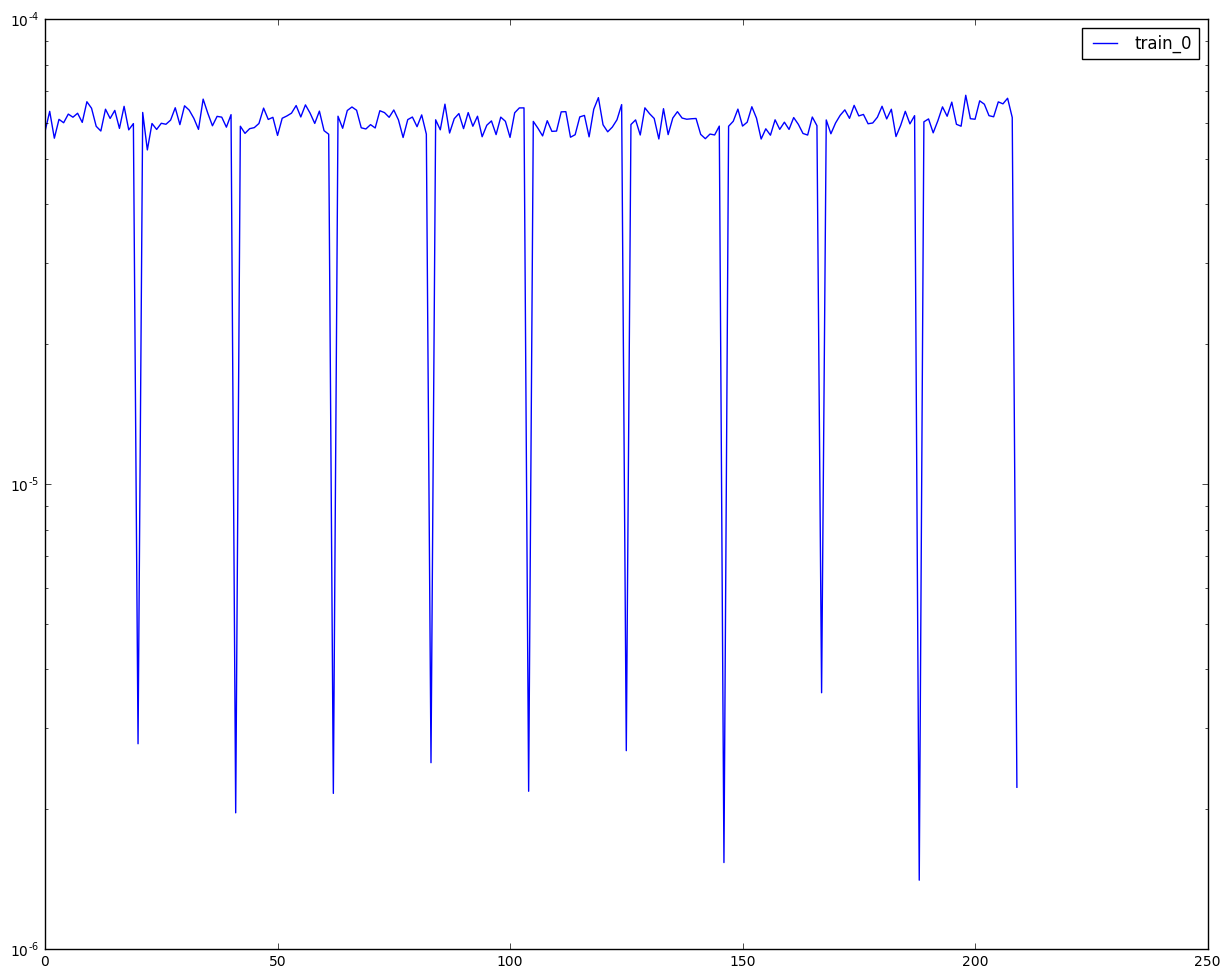

In [ ]:
plt.figure(figsize=(15, 12))
for k, (train_loss, val_loss) in enumerate(((opt_loss, val_loss),)):
    plt.semilogy(train_loss, label='train_{}'.format(k))
#     plt.semilogy(np.arange(len(val_loss)) * 20, val_loss, label='val_{}'.format(k))
plt.legend();

In [15]:
from rosenbrock import RosenbrockFunction

AA = T.scalar('a')
BB = T.scalar('b')
func_ = lambda theta: RosenbrockFunction(theta, AA, BB).func

sgd_fn = make_sgd(func_, var=[AA, BB])
momentum_fn = make_momentum(func_, var=[AA, BB])
lbfgs_fn = make_lbfgs(func_, m=10, init_lr=2e-4, var=[AA, BB])

non_lstm_optimizers = {
    'sgd': sgd_fn,
    'momentum': momentum_fn, 
    'lbfgs': lbfgs_fn
}

In [16]:
lstm_optimizers = {'chain': chain_optimizer}

In [17]:
from collections import namedtuple
TestCase = namedtuple('TestCase', 'n_iter n_functions')

In [18]:
tests = [
    TestCase(n_iter=20, n_functions=50), 
    TestCase(n_iter=60, n_functions=50),
    TestCase(n_iter=500, n_functions=50),
    TestCase(n_iter=500, n_functions=1)
]

tests_results = []

for n_iter, n_functions in tests:
    testing_options = {
        'n_iter'     : n_iter,
        'n_functions': n_functions,
        'sampler'    : multisampler,
        'normalize': True
    }
    histories = test_optimizers(lstm_optimizers, non_lstm_optimizers, **testing_options)
    tests_results.append(histories)

Testing lstm; chain
Testing momentum
Testing lbfgs
Testing sgd
Testing lstm; chain
Testing momentum
Testing lbfgs
Testing sgd
Testing lstm; chain
Testing momentum
Testing lbfgs
Testing sgd
Testing lstm; chain
Testing momentum
Testing lbfgs
Testing sgd


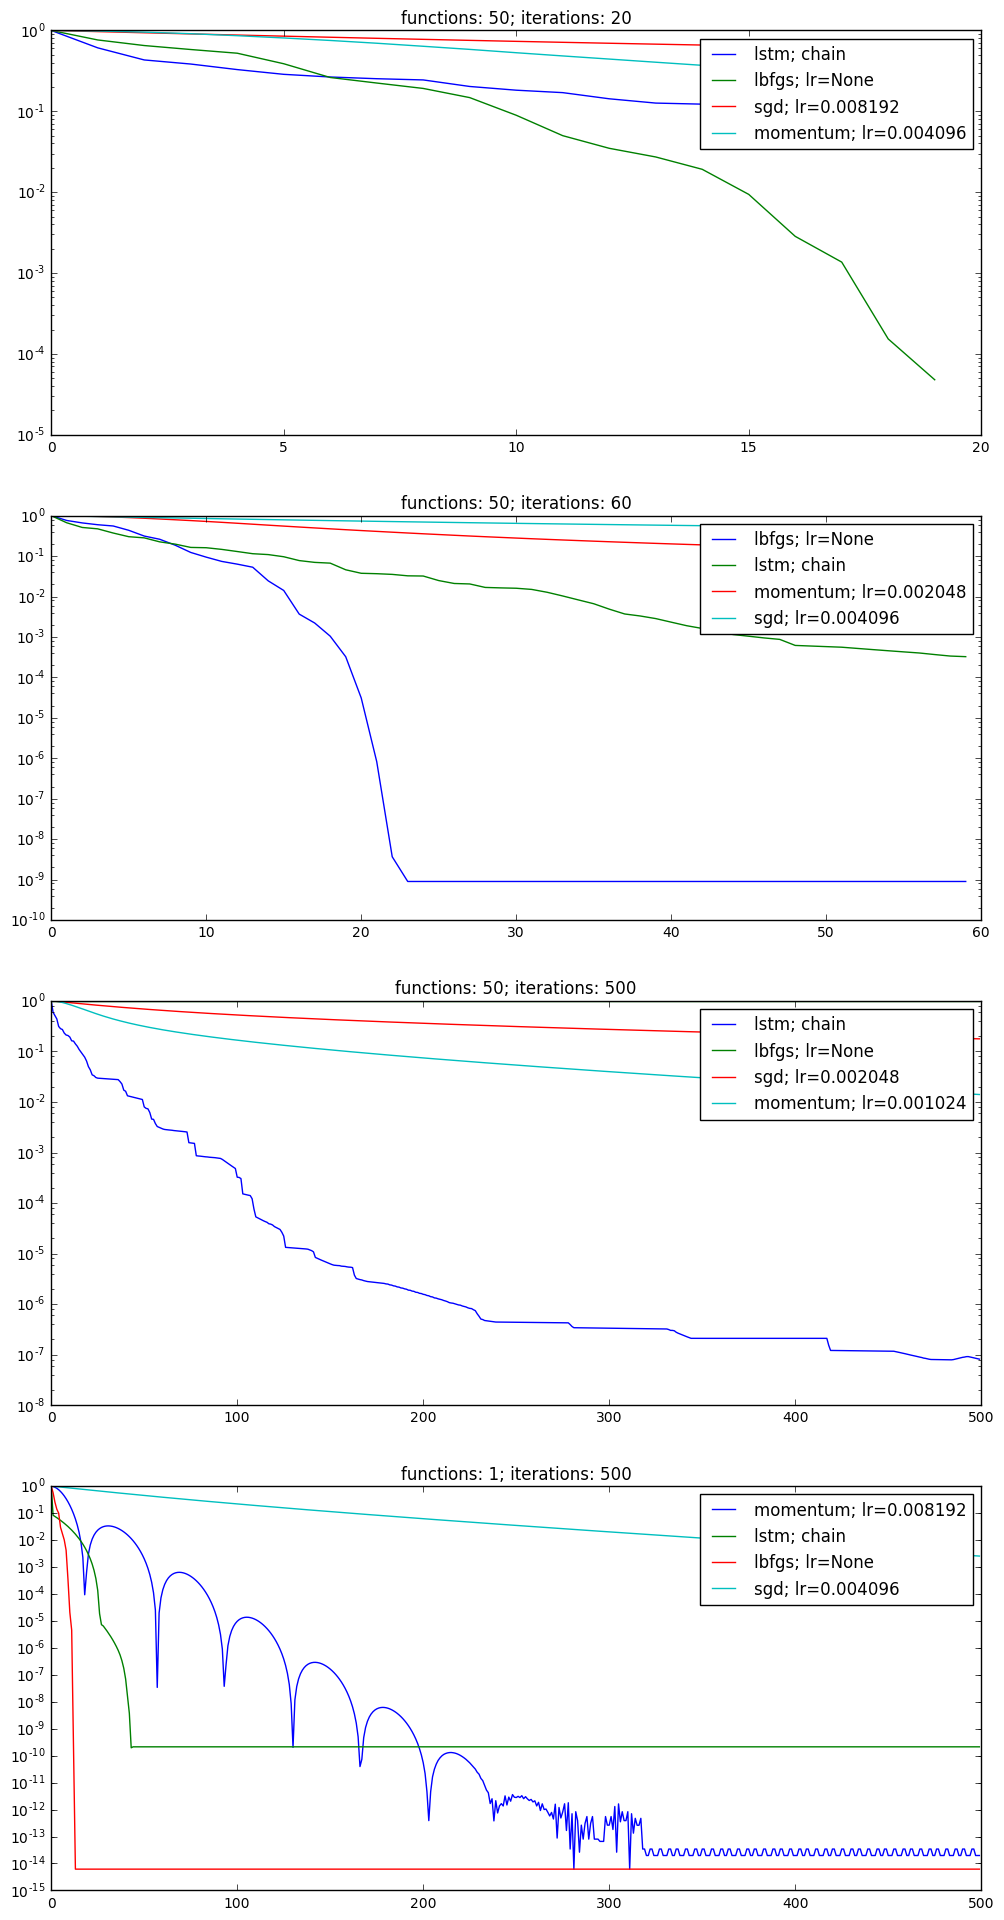

In [24]:
%matplotlib inline
fig, axes = plt.subplots(len(tests_results), figsize=(12, 6 * len(tests_results)))

if len(tests_results) == 1:
    axes = (axes,)

for ax, (n_iter, n_functions), h in zip(axes, tests, tests_results):
    for name, hist in h.items():
        ax.semilogy(hist, label=name)
    
    ax.set_title('functions: {}; iterations: {}'.format(n_functions, n_iter))
    ax.legend()
    
# fig.tight_layout()

(2.419656035743226, 5.854735331308624)


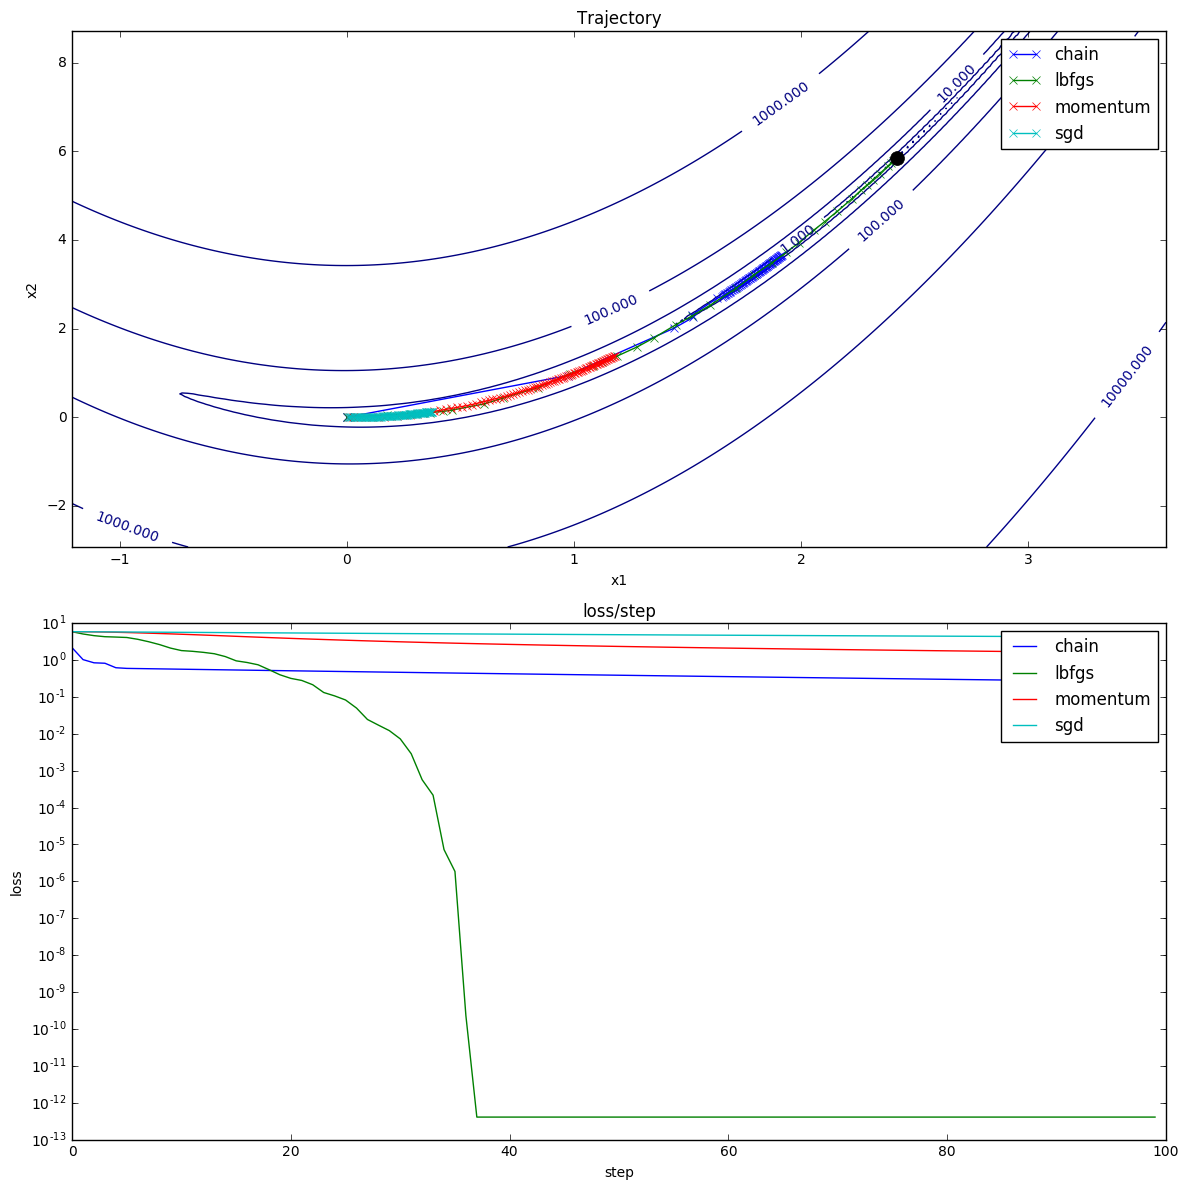

In [25]:
draw_trajectory(100, sample_point_and_params(ndim=2, sample_point=sample_point), lstm_optimizers, non_lstm_optimizers)

(1.9356508045202556, 3.746744037039913)


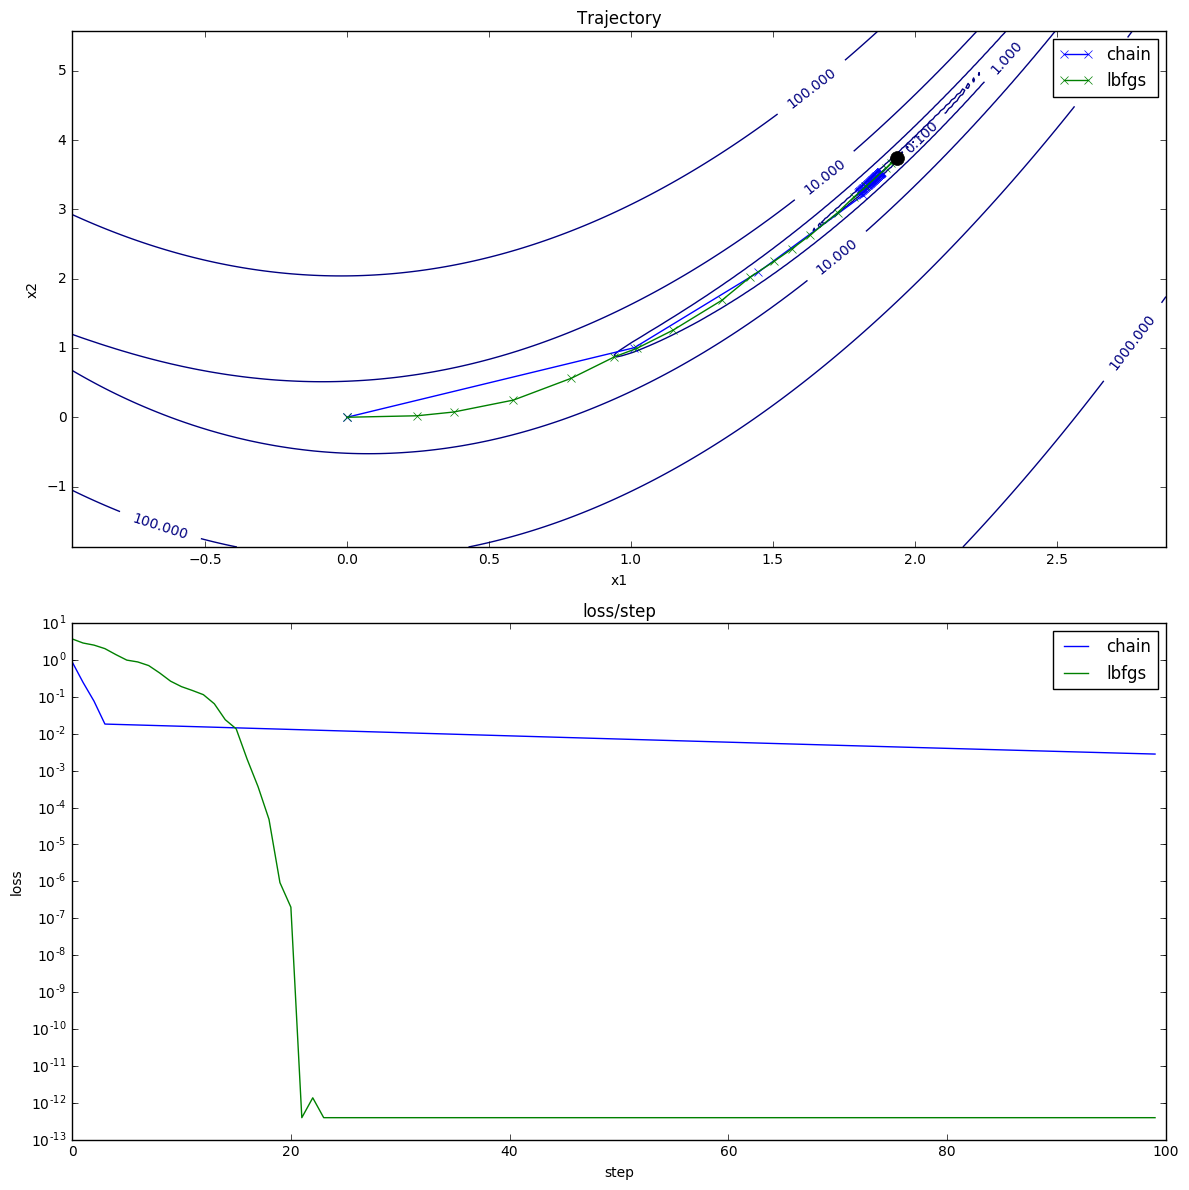

In [26]:
draw_trajectory(100, sample_point_and_params(ndim=2, sample_point=sample_point), lstm_optimizers, {k: v for k, v in non_lstm_optimizers.items() if k == 'lbfgs'})

(-0.38972915971675226, 0.1518888179335258)


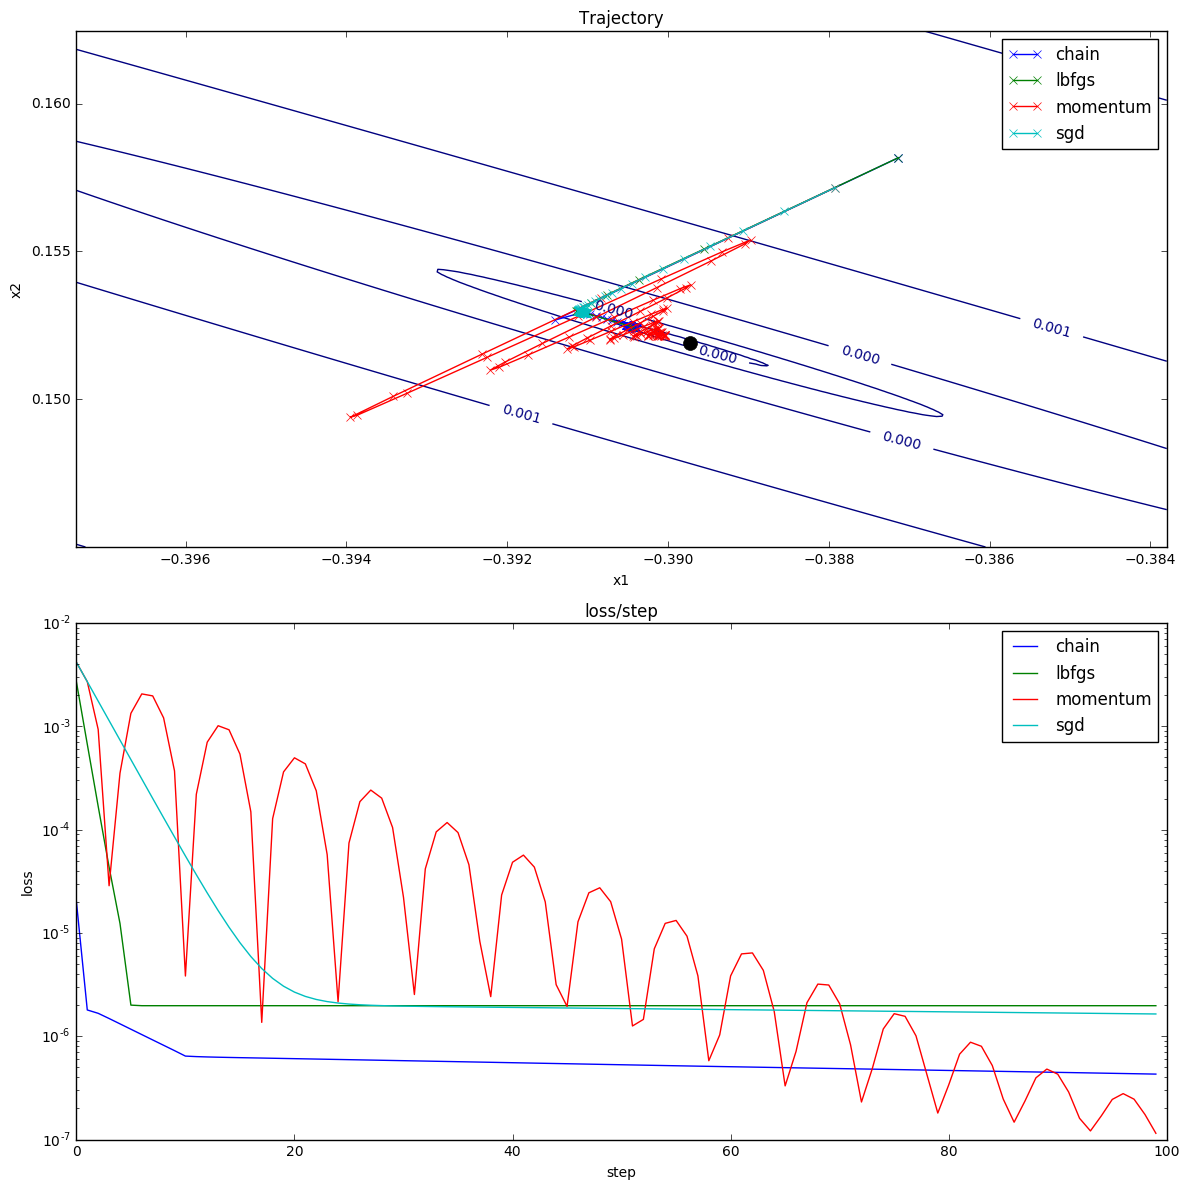

In [27]:
draw_trajectory(100, sample_point_and_params(ndim=2, sample_point=sample_point_second_phase), lstm_optimizers, non_lstm_optimizers)

(2.8146542269621815, 7.922278417356075)


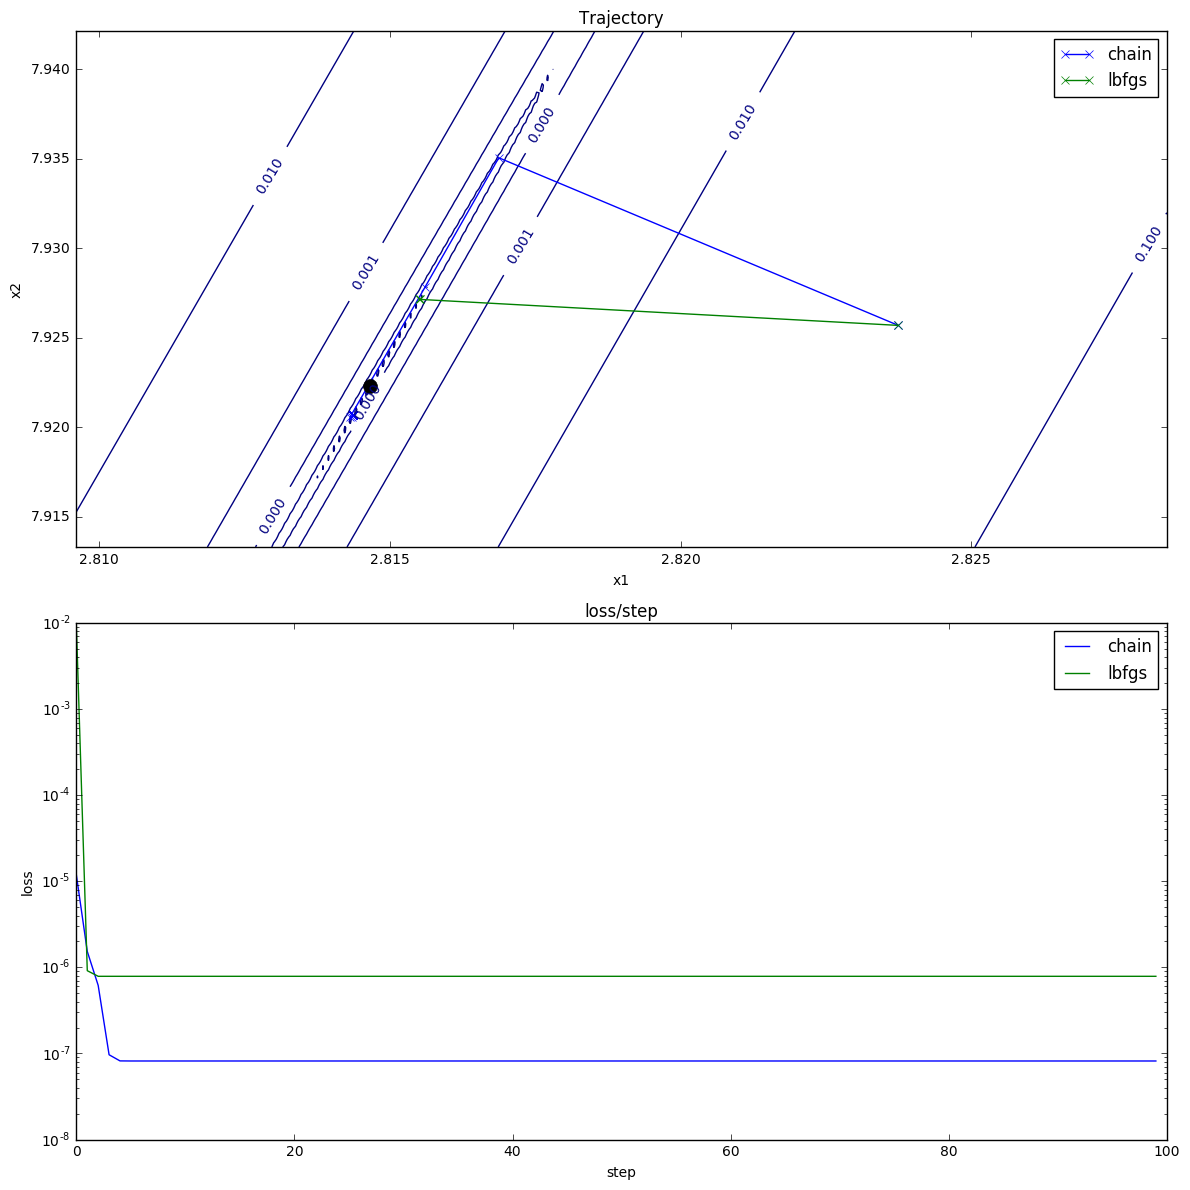

In [28]:
draw_trajectory(100, sample_point_and_params(ndim=2, sample_point=sample_point_second_phase), lstm_optimizers, {k: v for k, v in non_lstm_optimizers.items() if k == 'lbfgs'})

In [33]:
%timeit chain_optimizer.opts[0].loss_fn(train_inputs[0], 400, *train_inputs[1:]);

1 loop, best of 3: 1.17 s per loop


In [32]:
%timeit chain_optimizer.optimize(train_inputs[0], [train_inputs[1], train_inputs[2]], 20);

1 loop, best of 3: 15.5 s per loop


In [35]:
train_inputs[0].shape

(8016, 2)